In [1]:
import json
from sys import stderr
from matplotlib import pyplot as plt
from IPython.display import display, Markdown, Latex

from databinning import *
from mpc import *
from fpd import *


### Probabilistic models
Reads previously obtained probabilistic models.

In [2]:
f_x = np.load('./models/f_x.npy')
g_x = np.load('./models/g_x.npy')

### Parameters

In [3]:
# State dimension
x_dim = 2

# Input dimension
u_dim = 2

# Bounds for state and input
x_min = np.zeros(x_dim)
u_min = np.zeros(u_dim)

x_max = np.array([150, 100])
u_max = np.array([35, 0.35])

# Amount of bins for state and input
x_discr = np.array([300, 200])
u_discr = np.array([70, 35])

# Discretization step for state and input
x_step = np.array((x_max - x_min)/x_discr)
u_step = np.array((u_max - u_min)/u_discr)

In [4]:
x1_axis = [x_min[0] + (i + 0.5)*x_step[0] for i in range(x_discr[0])]
x2_axis = [x_min[1] + (i + 0.5)*x_step[1] for i in range(x_discr[1])]

x_axis = np.dstack((np.meshgrid(x1_axis, x2_axis)))

u1_axis = [u_min[0] + (i + 0.5)*u_step[0] for i in range(u_discr[0])]
u2_axis = [u_min[1] + (i + 0.5)*u_step[1] for i in range(u_discr[1])]

u_axis = np.dstack((np.meshgrid(u1_axis, u2_axis)))


### Simulation parameters
Defines the total simulation time and sampling time.

In [5]:
# Total simulation time: 24h (1440m)
total_time = 1440  

# Sample time: 1m
t_step = 1

# Number of control step: total_time/t_step = 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# References
LacI_ref = 23.48
TetR_ref = 10.00

### MPC Controller
Initialises the MPC controller used for online generation of the target policy.

In [6]:
setup_mpc = {
    'n_robust': 0,
    'n_horizon': 7,
    't_step': t_step,
    'store_full_solution': False
}

toggle = ToggleSwitchSimplifiedModel(False, LacI_ref, TetR_ref, t_step, total_time, 240)
model = toggle.get_model()
mpc_controller = ControllerMPC(toggle, t_step, setup_mpc, False)
simulator = mpc_controller.simulator
estimator = mpc_controller.estimator
mpc = mpc_controller.controller


### Control from demonstration
Defines the main loop of the algorithm control from demonstration.

In [7]:
episodes = 10

states = np.zeros((episodes, steps, x_dim))
inputs = np.zeros((episodes, steps, u_dim))

In [8]:
%%capture

for e in range(episodes):

    x_0 = np.array([20.68, 2.11])
    toggleswitch = ToggleSwitchSimplified()
    toggleswitch.initialState(x_0)

    fpd = ControllerFPD(f_x, g_x, toggleswitch)

    mpc.reset_history()
    mpc.x0 = x_0

    mpc.set_initial_guess()

    for k in range(steps):

        u_target = mpc.make_step(x_0)

        if (mpc.t0 - t_step) % 15 == 0:
            uk = fpd.makeFPDStep(u_target[:, 0], u_step, u_discr, u_axis, x_dim, x_min, x_step, x_max)
            ukm1 = uk
        else:
            uk = ukm1

        y_next = simulator.make_step(uk)
        x_0 = estimator.make_step(y_next)
        inputs[e, k] = uk[:, 0]

    states[e] = np.array(mpc.data['_x'].tolist())

    toggle.set_trajectories(states[e], inputs[e])
    toggle.export_results('constraints', 'results' + str(e), 'w')


In [9]:
display(Markdown('#### Performance metrics'))
metrics = """
<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | {ISE}     |
| ITAE       | {ITAE}    |
""".format(ISE="{:.2f}".format(toggle.trajectories['ISE']), ITAE=format(toggle.trajectories['ITAE'], '.2e'))

display(Markdown(metrics))

#### Performance metrics


<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | 261.24     |
| ITAE       | 3.42e+05    |


### Results plot

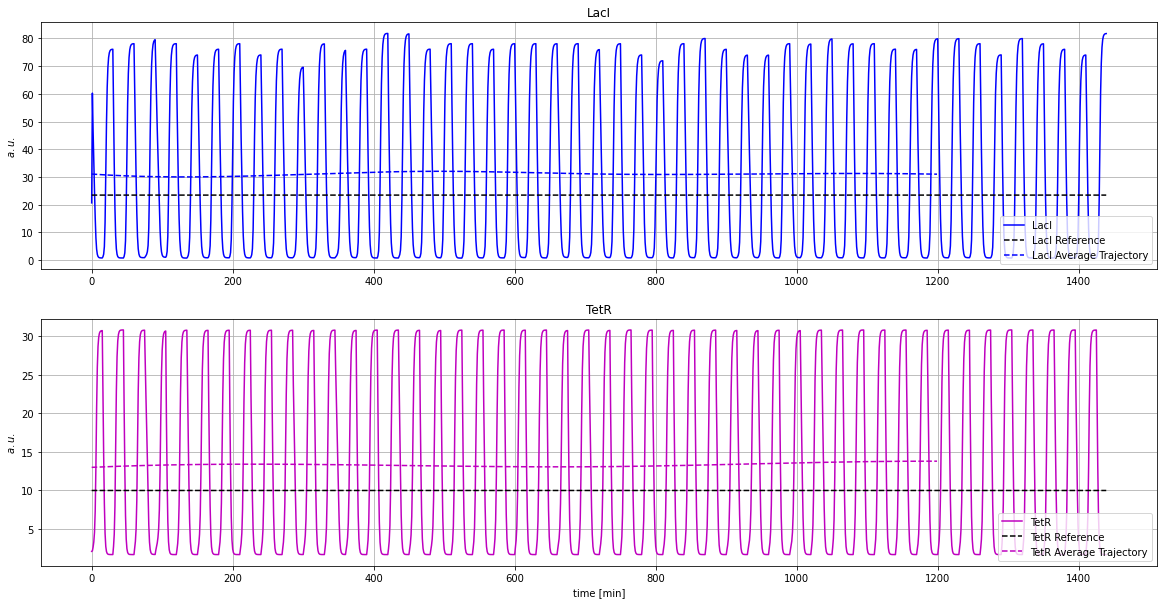

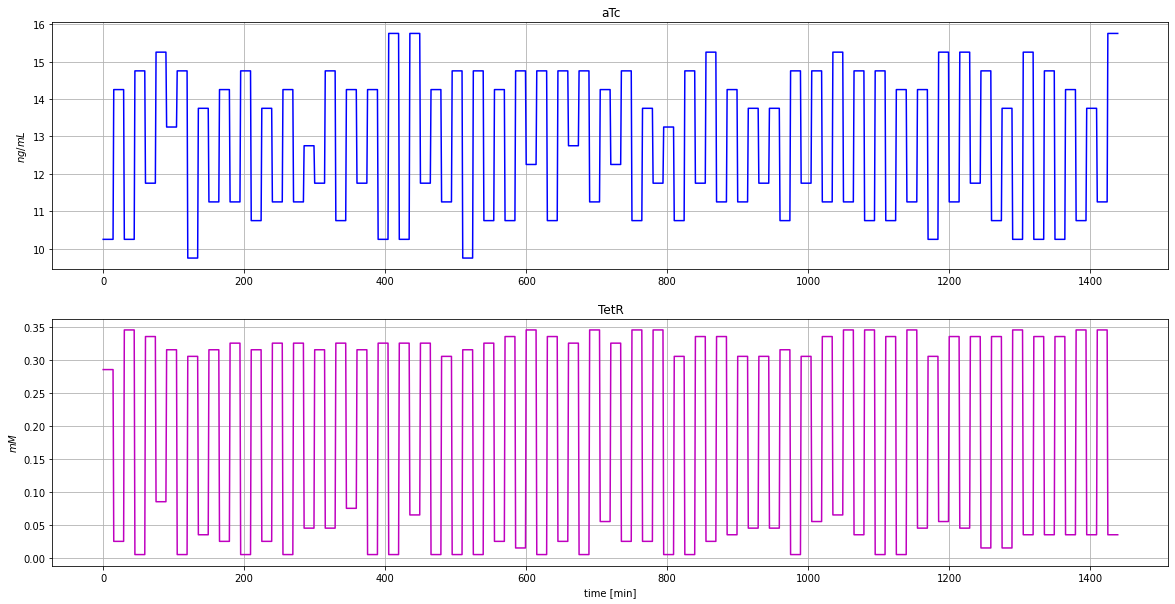

In [10]:
avg_samples_range = int(avg_period/t_step)
avg_x = np.arange(0, total_time, avg_period)
avg_stop_time = total_time - ((total_time-1) % avg_period) - 1
avg_time = np.arange(0, avg_stop_time, t_step)

fig_x = 20
fig_y = 10

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 16

figure, axes = plt.subplots(2, figsize=(fig_x, fig_y))

time = np.arange(0, total_time, t_step)

axes[0].set_ylabel(r'$a.u.$')
axes[0].set_title('LacI')
LacI_line, = axes[0].plot(time, toggle.trajectories['states']['LacI'], color='b')
ref_LacI_line, = axes[0].plot(time, LacI_ref*np.ones(len(time)), color='k', linestyle='--')
avg_LacI_line, = axes[0].plot(avg_time, toggle.trajectories['avg_traj']['LacI'], color='b', linestyle='--')
axes[0].legend(['LacI', 'LacI Reference', 'LacI Average Trajectory'], loc='lower right')

axes[1].set_ylabel(r'$a.u.$')
axes[1].set_title('TetR')
TetR_line, = axes[1].plot(time, toggle.trajectories['states']['TetR'], color='m')
ref_TetR_line, = axes[1].plot(time, TetR_ref*np.ones(len(time)), color='k', linestyle='--')
avg_TetR_line, = axes[1].plot(avg_time, toggle.trajectories['avg_traj']['TetR'], color='m', linestyle='--')
axes[1].legend(['TetR', 'TetR Reference', 'TetR Average Trajectory'], loc='lower right')
axes[1].set_xlabel('time [min]')

figure.set_facecolor("white")

figure_input, axes = plt.subplots(2, figsize=(fig_x, fig_y))

time = np.arange(0, total_time, t_step)

axes[0].set_ylabel(r'$ng/mL$')
axes[0].set_title('aTc')
aTc_line, = axes[0].plot(time, toggle.trajectories['inputs']['aTc'], color='b')

axes[1].set_ylabel(r'$mM$')
axes[1].set_title('TetR')
iptg_line, = axes[1].plot(time, toggle.trajectories['inputs']['IPTG'], color='m')
axes[1].set_xlabel('time [min]')

figure_input.set_facecolor("white")

lines = np.array([LacI_line, avg_LacI_line, ref_LacI_line, TetR_line, avg_TetR_line, ref_TetR_line])


### Plots animation
It animates closed-loop simulations and exports them in mp4 format.

In [11]:
toggle.animate_results('constraints', 'proteins', toggle.update_protein, figure, (time, avg_time, LacI_ref, TetR_ref, lines), steps)
toggle.animate_results('constraints', 'inputs', toggle.update_inputs, figure_input, (time, np.array([aTc_line, iptg_line])), steps)

#### Mean and standard deviation between the trajectories obtained in the different episodes

In [12]:
states = np.zeros((episodes, steps, x_dim))

for i in range(episodes):
    with open('./data/constraints/results' + str(i) + '.json') as f:
        data = json.load(f)
        states[i, :, 0] = data['states']['LacI']
        states[i, :, 1] = data['states']['TetR']

states_mean = np.array([[np.mean(states[:, i, 0]), np.mean(states[:, i, 1])] for i in range(steps)])
states_std = np.array([[np.std(states[:, i, 0]), np.std(states[:, i, 1])] for i in range(steps)])

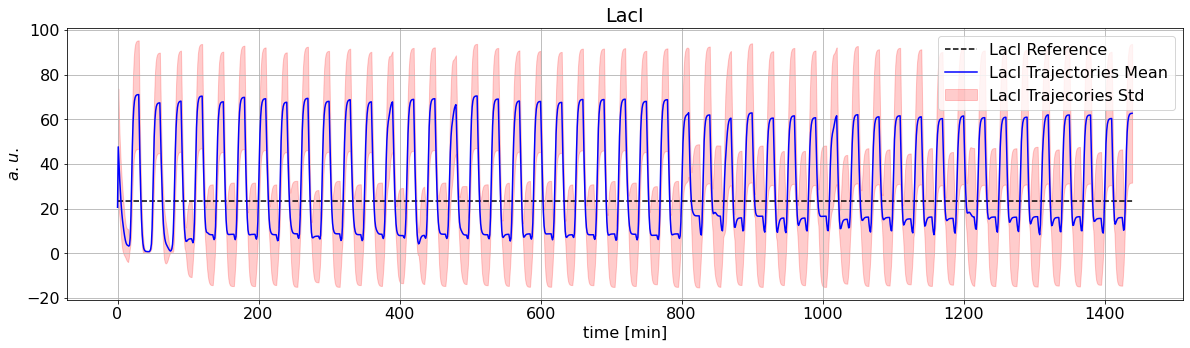

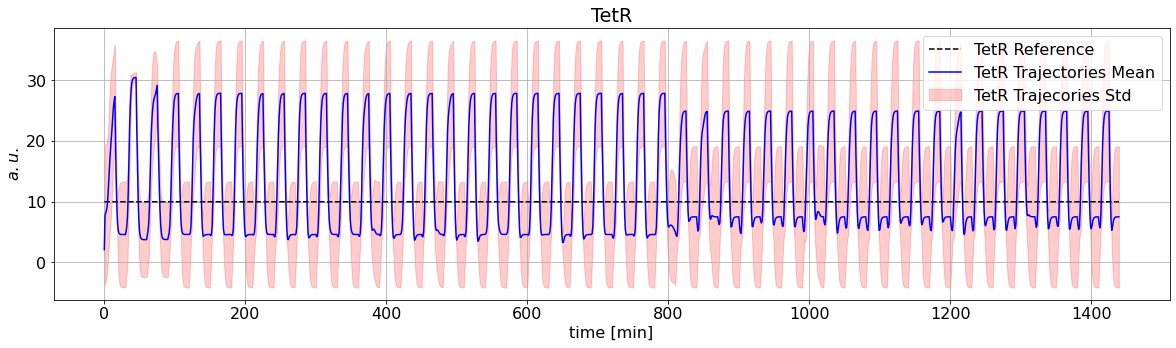

In [13]:
fig_x = 20
fig_y = 5

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 16

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

time = np.arange(0, total_time, t_step)

axes.set_ylabel(r'$a.u.$')
axes.set_title('LacI')
axes.plot(time, LacI_ref*np.ones(len(time)), color='k', linestyle='--')
axes.plot(time, states_mean[:, 0], color='b')
axes.fill_between(time, states_mean[:, 0] - states_std[:, 0], states_mean[:, 0] + states_std[:, 0], color='r', alpha=0.2)
axes.legend(['LacI Reference', 'LacI Trajectories Mean', 'LacI Trajecories Std'], loc='upper right')
axes.set_xlabel('time [min]')

figure.set_facecolor("white")
figure.savefig('./data/constraints/average_trajectory/LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$a.u.$')
axes.set_title('TetR')
axes.plot(time, TetR_ref*np.ones(len(time)), color='k', linestyle='--')
axes.plot(time, states_mean[:, 1], color='b')
axes.fill_between(time, states_mean[:, 1] - states_std[:, 1], states_mean[:, 1] + states_std[:, 1], color='r', alpha=0.2)
axes.legend(['TetR Reference', 'TetR Trajectories Mean', 'TetR Trajecories Std'], loc='upper right')
axes.set_xlabel('time [min]')


figure.set_facecolor("white")
figure.savefig('./data/constraints/average_trajectory/TetR.png')


#### Mean and standard deviation between the average trajectories

In [14]:
average_states = np.zeros((episodes, avg_stop_time, x_dim))

for i in range(episodes):
    with open('./data/constraints/results' + str(i) + '.json') as f:
        data = json.load(f)
        average_states[i, :, 0] = data['avg_traj']['LacI']
        average_states[i, :, 1] = data['avg_traj']['TetR']

In [15]:
mean = np.zeros((avg_stop_time, x_dim))
std = np.zeros((avg_stop_time, x_dim))

for i in range(avg_stop_time):
    mean[i] = np.array([np.mean(average_states[:, i, 0]), np.mean(average_states[:, i, 1])])
    std[i] = np.array([np.std(average_states[:, i, 0]), np.std(average_states[:, i, 1])])

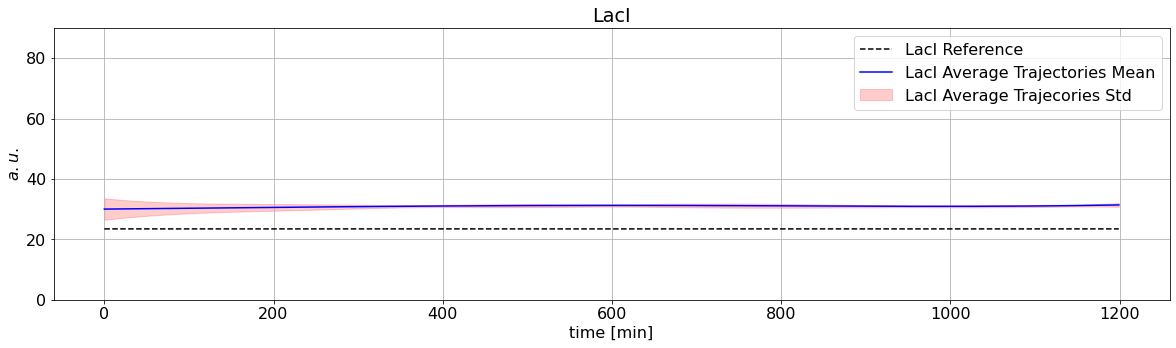

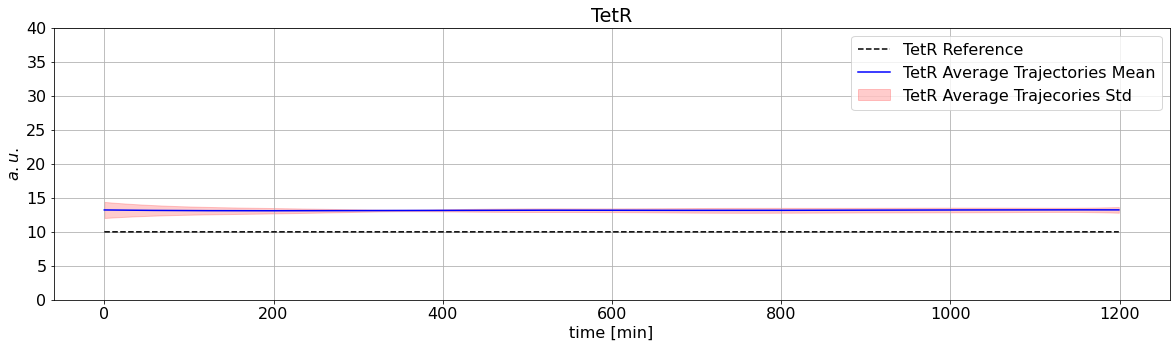

In [16]:
fig_x = 20
fig_y = 5

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 16

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$a.u.$')
axes.set_title('LacI')
axes.plot(avg_time, LacI_ref*np.ones(len(avg_time)), color='k', linestyle='--')
axes.plot(avg_time, mean[:, 0], color='b')
axes.fill_between(avg_time, mean[:, 0] - std[:, 0], mean[:, 0] + std[:, 0], color='r', alpha=0.2)
axes.legend(['LacI Reference', 'LacI Average Trajectories Mean', 'LacI Average Trajecories Std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_ylim(0, 90)


figure.set_facecolor("white")
figure.savefig('./data/constraints/mean_and_std/LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$a.u.$')
axes.set_title('TetR')
axes.plot(avg_time, TetR_ref*np.ones(len(avg_time)), color='k', linestyle='--')
axes.plot(avg_time, mean[:, 1], color='b')
axes.fill_between(avg_time, mean[:, 1] - std[:, 1], mean[:, 1] + std[:, 1], color='r', alpha=0.2)
axes.legend(['TetR Reference', 'TetR Average Trajectories Mean', 'TetR Average Trajecories Std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_ylim(0, 40)


figure.set_facecolor("white")
figure.savefig('./data/constraints/mean_and_std/TetR.png')